### Agentic RAG with Langraph

In [83]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph , END
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pinecone.grpc import PineconeGRPC as Pinecone
from sentence_transformers import SentenceTransformer
from langchain_core.documents import Document

In [84]:
from dotenv import load_dotenv
load_dotenv()

True

In [85]:
llm = ChatGroq(groq_api_key= os.getenv("NEW_GROQ_API_KEY") , model_name="llama-3.1-8b-instant",temperature=0.1,max_tokens=1024)
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000016EDF768AA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000016EDF76AF60>, model_name='llama-3.1-8b-instant', temperature=0.1, model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=1024)

### State Definition

In [86]:
class AgentState(TypedDict):
    question: str
    documents: List[str]
    ans: str
    needs_retrieval : bool

### Agentic Function

In [ ]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]
    
    prompt = f"""
You are an AI controller in a Retrieval-Augmented Generation (RAG) system.

Task:
Decide whether external knowledge retrieval is REQUIRED to answer the user query correctly and confidently.

Rules:
- Choose RETRIEVE if the query:
  - Refers to specific documents, standards, datasets, or user-provided files
  - Requires precise, technical, or domain-specific information
  - Cannot be answered confidently without external sources
- Choose GENERATE if the query:
  - Is conversational or opinion-based
  - Can be answered accurately using general knowledge alone

Important:
- If you are uncertain, choose RETRIEVE.

User Query:
"{question}"

Respond with ONLY one word:
RETRIEVE or GENERATE

"""
    response = llm.invoke(prompt)
    decision = response.content.strip().upper()
    if decision not in {"RETRIEVE", "GENERATE"}:
      decision = "RETRIEVE"  # safe default
    needs_retrieval = decision == "RETRIEVE"
    return {**state, "needs_retrieval": needs_retrieval}

In [88]:
def retrieve_document(state: AgentState) ->AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    # Pinecone Configuration
    pinecone_api_key = os.getenv("PINECONE_API_KEY")
    pinecone_env = os.getenv("PINECONE_ENVIRONMENT")
    pc = Pinecone(api_key=pinecone_api_key)
    index_name = "academic-rag"
    
    host = os.getenv("PINECONE_HOST_ACAD")
    index = pc.Index(host= host)

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
    query_embedding = model.encode(question).tolist()
    matching_result = index.query(
        vector=query_embedding,
        top_k=3,
        namespace="rag-docs",
        include_metadata=True
    )

    context = []
    for doc in matching_result.matches:
        context.append(doc.metadata['text'])
    if not context:
        return "No relevant context found to answer the question."
    
    return {**state, "documents": context}

In [89]:
def generate_answer(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    context = state["documents"]

    if context:
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {question}

Answer:"""
    else:
        prompt = f"Answer the following question: {question}"
    
    response = llm.invoke(prompt)
    answer = response.content
    return {**state, "ans": answer}

### Conditional Logic

In [90]:
def should_retrieve(state: AgentState) ->str:
     """
    Determine the next step based on retrieval decision
    """
     if state["needs_retrieval"]:
          return "retrieve"
     else:
          return "generate"

### Build the graph

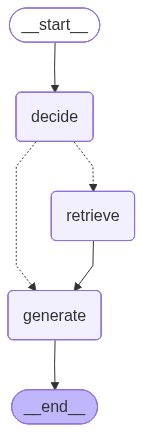

In [91]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide",decide_retrieval)
workflow.add_node("retrieve",retrieve_document)
workflow.add_node("generate",generate_answer)

# Set entry point
workflow.set_entry_point("decide")

# Add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

# Add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()
app

### Test The System

In [92]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }
    
    result = app.invoke(initial_state)
    return result

In [93]:
# Test with a question that should trigger retrieval
result = ask_question("Hello buddy")
print("Answer:\n", result["ans"])
print("Docs used:", len(result["documents"]))

Answer:
 Hello back to you. How are you today?
Docs used: 0


In [94]:
result

{'question': 'Hello buddy',
 'documents': [],
 'ans': 'Hello back to you. How are you today?',
 'needs_retrieval': False}

In [95]:
result = ask_question("all subjects in 6th sem ")
print("Answer:\n", result["ans"])
print("Docs used:", len(result["documents"]))

Answer:
 For the 6th semester, the subjects are as follows:

**B.Tech (Computer Science and Engineering-Core)**

1. TCS-601 Compiler Design (DC, 3 credits)
2. TCS-611 Software Engineering (DC, 3 credits)
3. TCS-604 Computer Networks-I (DC, 3 credits)
4. TCS-693 Full Stack Web Development (DC, 3 credits)
5. Discipline Specific Elective-III (DE/GE, 3 credits)
   - Options: 
     - TCS-692 Large Language Models and Generative AI
     - TCS-651 Devops on cloud
     - TCS-675 Introduction to Virtual Reality
     - TCS-619 Network and system security
     - TCS-695 Security and Auditing
     - TCS-671 Bigdata Storage and Processing
     - TCS-680 Parallel Computer Architecture (Through SWAYAM)
6. PCS-601 Compiler Design Lab (DC, 2 credits)
7. PCS-604 Computer Networks Lab (DC, 2 credits)
8. PCS-693 Web Development Lab (DC, 2 credits)
9. XCS-601 Career Skills (VA, 1 credit)
10. PESE 600 Practical for Employability Skill Enhancement (SEC, 1 credit)
11. SCS-601 MOOCS Seminar (VA, 1 credit)
12. 

In [96]:
result

{'question': 'all subjects in 6th sem ',
 'documents': ['2023-24 and 2024-25 onwards \n \n \nB.Tech (Computer Science and Engineering-Core) \n \n \nSEMESTER: VI   \n \nCOURSE MODULE \nCOURSE Credit\ns Code Title Compo\nnent \nTCS-601 Compiler Design DC 3 \nTCS-611 Software Engineering DC 3 \nTCS-604 Computer Networks-I DC 3 \nTCS-693 Full Stack Web \nDevelopment DC 3 \n Discipline Specific \nElective-III DE/GE 3 \nPCS-601 Compiler Design Lab DC 2 \nPCS-604 Computer Networks \nLab DC 2 \nPCS-693 Web Development \nLab DC 2 \nXCS-601 Career Skills VA 1 \nPESE 600 Practical for \nEmployability Skill \nEnhancement \nSEC 1 \nSCS-601 MOOCS Seminar VA 1 \nGP-601 General Proficiency SE 1 \n \n \nDISCIPLINE SPECIFIC ELECTIVE-III    \n \nCOURSE \nCODE \nCOURSE NAME \nTCS-692 Large Language Models and Generative AI \nTCS-651 Devops on cloud \nTCS-675 Introduction to Virtual Reality \nTCS-619 Network and system security \nTCS-695 Security and Auditing \nTCS-671 Bigdata Storage and Processing \nTCS-

In [97]:
result = ask_question("all subjects in 6th sem with their credits")
print("Answer:\n", result["ans"])
print("Docs used:", len(result["documents"]))

Answer:
 Based on the given context, the subjects in the 6th semester with their credits are:

1. TCS-601 Compiler Design - 3 credits
2. TCS-611 Software Engineering - 3 credits
3. TCS-604 Computer Networks-I - 3 credits
4. TCS-693 Full Stack Web Development - 3 credits
5. Discipline Specific Elective-III (DE/GE) - 3 credits
   - Options: 
     - TCS-692 Large Language Models and Generative AI
     - TCS-651 Devops on cloud
     - TCS-675 Introduction to Virtual Reality
     - TCS-619 Network and system security
     - TCS-695 Security and Auditing
     - TCS-671 Bigdata Storage and Processing
     - TCS-680 Parallel Computer Architecture (Through SWAYAM)
6. PCS-601 Compiler Design Lab - 2 credits
7. PCS-604 Computer Networks Lab - 2 credits
8. PCS-693 Web Development Lab - 2 credits
9. XCS-601 Career Skills - 1 credit
10. PESE 600 Practical for Employability Skill Enhancement - 1 credit
11. SEC 1 - 1 credit
12. SCS-601 MOOCS Seminar - 1 credit
13. GP-601 General Proficiency - 1 credit

In [99]:
result = ask_question("Whats your model name")
print("Answer:\n", result["ans"])
print("Docs used:", len(result["documents"]))

Answer:
 I'm an AI model known as Llama. Llama stands for "Large Language Model Meta AI".
Docs used: 0
